# Preparation
Before you have to do something we will show you some basics on dataloading and preprocessing on the dataset used in this challenge as well as a basic network setup.  
You can than later re-use parts of this to make your life a little bit easier, but you don't have to.

In [2]:
import pathlib

import torch

from torch.utils.data import Dataset
from torchvision.io import read_image

In [3]:
torch.cuda.is_available()

x = torch.rand(5,4,3)

## Data loading

To work with any kind of data we first have to load it. For this we use a dataloader that reads the images as well as their labels and transforms them into pytorch readable tensors.

In [4]:
class RSiMCCDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
        # get images
        image_files = [x.resolve() for x in pathlib.Path(".").glob('data/*/*')]
        # Image.open() has a bug, this is a workaround
        self.images=[read_image(str(p)) for p in image_files] 
        # get labels from image path
        labels = [x.parts[-2] for x in image_files]
        self.classes = sorted(list(set(labels)))
        self.labels = [self.label_to_tensor(lbl) for lbl in labels]

        assert len(self.labels) == len(self.images), f"Found {len(self.labels)} labels and {len(self.images)} images"

    def label_to_tensor(self, lbl):
        """
        Converts the string label to a one-hot tensor where every entry is zero except the label which is one.
        
        """
        assert lbl in self.classes, f"Class {lbl} not a valid class (valid classes: {self.classes})"
        t = torch.zeros(len(self.classes))
        t[self.classes.index(lbl)] = 1
        return t

    def tensor_to_label(self, t):
        """
        Returns the classname in string format
        """
        assert len(t.shape) == 1, f"Can only convert 1-dimensional tensors (shape of tensor: {t.shape})"
        assert len(t) == len(self.classes), f"Lenght of tensor ({len(t)}) does not match number of classes ({len(classes)})"
        return self.classes[t.argmax()]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].float()/255
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

## Examples
Now lets load the dataset and look at some examples by just randomly loading the images and their labels

In [5]:
ds = RSiMCCDataset()

In [6]:
print(f"The dataset consists of {len(ds)} RGB images of shape {ds.images[0].shape} labeled in {ds.labels[0].shape[0]} classes which are " + ', '.join(ds.classes))

The dataset consists of 11519 RGB images of shape torch.Size([3, 64, 64]) labeled in 10 classes which are AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake


In [22]:
ds.labels[0]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

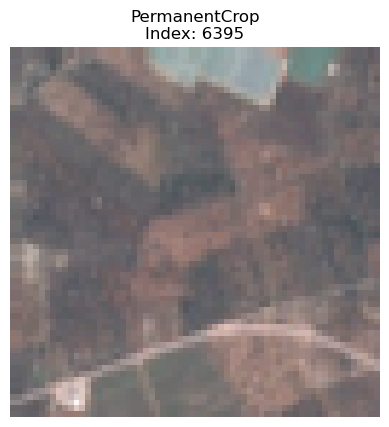

In [7]:
import matplotlib.pyplot as plt
import random

r = random.randint(0, len(ds))
img, lbl = ds[r]

# Display the image
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(ds.tensor_to_label(lbl) + "\nIndex: " + str(r))
plt.show()

In [8]:
ds.labels[0]

ds[0][0].shape

torch.Size([3, 64, 64])

## Model creation
Next up we need to create a model that should be trained using our data.  
For this we will be using a pre-defined model from pytorch.

*Note: We are not training or evaluating here, this is later your task to decide how to.*

In [9]:
from torchvision.models import resnet18 as def_net
from torchvision.models import ResNet18_Weights as def_weight 

model = def_net(num_classes=len(ds.classes))

Let's check if this works - this is not about accuracy but just to see if the model runs with our data

In [10]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

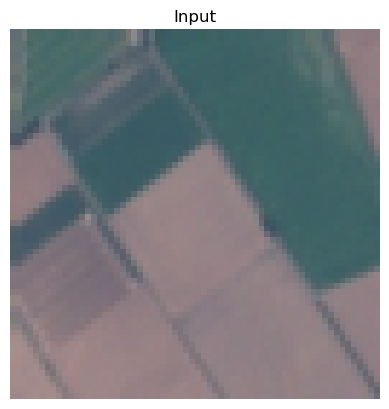

Result: Industrial
Actual: AnnualCrop


In [11]:
from torch.utils.data import DataLoader

# run model
model.eval()
dl = DataLoader(dataset=ds, num_workers=4, batch_size=1, shuffle=True)
batch = next(iter(dl))
res = model(batch[0])

# show results
plt.imshow(batch[0].squeeze().permute(1, 2, 0))
plt.axis('off')
plt.title("Input")
plt.show()

print(f"Result: {ds.tensor_to_label(res.squeeze())}")
print(f"Actual: {ds.tensor_to_label(batch[1].squeeze())}")

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self)

In [ ]:
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)




# Coding Challenge
Now that you saw how the data and model could be loaded it is your task to create a model that performs better. For this please fill out the functions in [`CodingChallenge.py`](CodingChallenge.py).  
You may re-use code from this notebook if you wish to and you don't have to re-invent the wheel.

To fully complete the challenge you have to
1. Analyze the data
   * How you do this is up to you and optional codes created in this step don't have to be submitted.
2. Load the data
   * This may include additional steps then just loading
3. Load a model
   * Beware of changes to the model that may apply
   * Your model can be based on an existing architecture (like above) or custom
4. Train the model
   * This may include several steps
5. Evaluate the model
   * The result should be a single score applicable to this task
6. Summarize your findings
   * This may include results of the training process or anything else you want to share

In [12]:
import CodingChallenge as CodingChallenge
# creating model and dataset
my_model = CodingChallenge.get_my_model()
my_ds = CodingChallenge.get_my_ds()

In [13]:
my_model

Ellipsis

In [ ]:
# train the model
my_model = CodingChallenge.train(my_model, my_ds)

In [ ]:
# evaluate the model
the_final_score = CodingChallenge.final_evaluate(my_model, my_ds)

In [ ]:
# summarize the findings
CodingChallenge.summary()

# Documentation

For the documentation of you work, please write a short (max. 2 pages) report including but not limited to:

1. Discuss the data analysis and your observations (using plots, tables, statistical reports, etc.)
2. Provide a description of the model you selected, evaluation metric(s) and the result.
3. Provide details of the selected deep model learning procedure (hyperparameters, augmentations if any, loss curves, etc.).
4. Discuss the methods that can be used for improving the result of your training. Methods of this discussion don't have to be implemented by you.
5. Discuss your observations and potential problems and possible improvements to your current solution.

For all points you may add references (e.g. for methods) from the scientific literature when appropriate. References don't count to your 2 page limit.

# Submission

For the submission, please submit a **single zip file** called `<LastName>_<FirstName>_cv4rs_cc.zip` containing **exacly** two files:

1. Your report as `report_<LastName>_<FirstName>.pdf`
2. Your code as `CodingChallenge.py`

Please do **not submit** the `CodingChallenge.ipynb` - any changes on this file will not be graded.

Note, that only your code is to be submitted and no model checkpoints or similar. Therefore you should take scientific practices like reproducablity into account.

## Examples:
1. Name: Max Mustermann  
   Submission:
   ```
       .  
       └── Mustermann_Max_cv4rs_cc.zip  
           ├── report_Mustermann_Max.pdf  
           └── CodingChallenge.py
   ```  


3. Name: Marie Anna Musterfrau  
   Submission:
   ```
       .  
       └── Musterfrau_Marie_cv4rs_cc.zip  
           ├── report_Musterfrau_Marie.pdf  
           └── CodingChallenge.py  
   ```
       